In [5]:
# 멀티모달 기본 이해 - 이미지를 읽어 LLM이 설명
!pip install -U langchain langchain-core langchain-community langchain-google-genai google-genai
!pip install -U sentence-transformers

In [8]:
import base64
from pathlib import Path
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
import os
from dotenv import load_dotenv
from google.colab import userdata # Colab 환경에서 보안 정보를 가져오기 위해 userdata 모듈 임포트
load_dotenv() # .env 파일에서 환경 변수를 로드

# Gemini 모델 초기화 및 설정
vison_llm = ChatGoogleGenerativeAI(
    temperature=0.2,  # 모델의 창의성(무작위성)을 0.2로 설정 (낮은 값은 더 결정론적이고 일관된 응답을 유도)
    model="gemini-2.5-flash", # 이미지 분석에 최적화된 빠른 멀티모달 모델 사용
    google_api_key=userdata.get('GOOGLE_API_KEY') # Colab의 보안 저장소에서 API 키를 가져와 설정
)

사진 설명 : 

이미지에는 다정하게 마주 보고 있는 젊은 커플이 담겨 있습니다. 두 사람은 이마를 맞대고 손을 잡은 채 환하게 웃고 있으며, 행복한 순간을 공유하고 있습니다. 남성은 베이지색 코트를, 여성은 니트 모자와 스카프를 착용하여 겨울 분위기를 연출합니다. 여성은 선명한 빨간색 립스틱으로 포인트를 주었습니다. 배경에는 흐릿하게 빛나는 전구들이 보여 로맨틱하고 따뜻한 느낌을 더합니다.

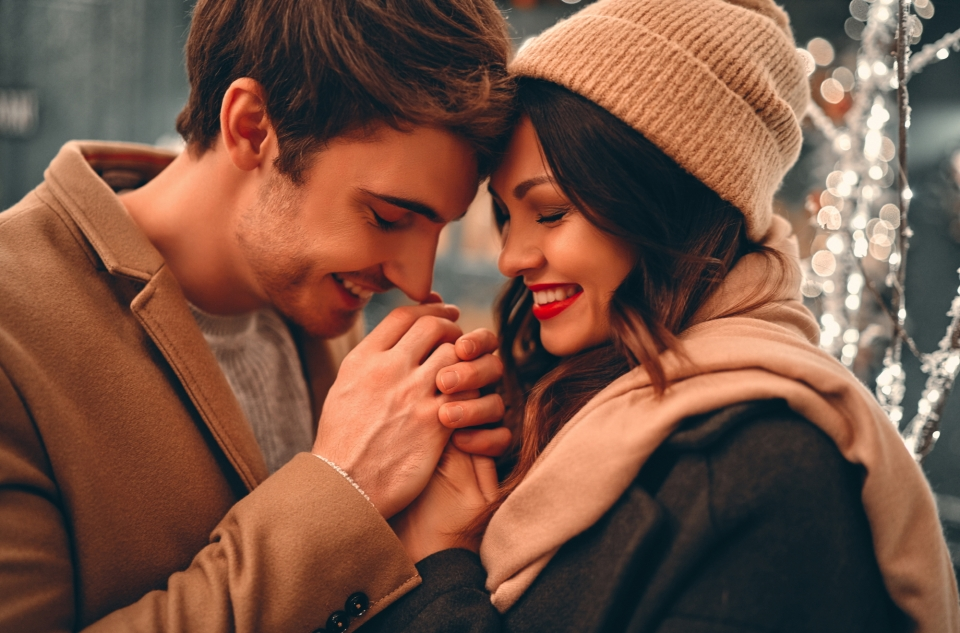

In [13]:
# 이미지를 base64 Data url(data:image/....)로 변환하는 함수
def encode_image_to_data_urlFunc(image_path:str) -> str:
  # 랭체인/Gemini에서 사용하는 Data URL 형식에 맞추기 위해 파일 확장자를 확인하고 준비
  #gemini는 jpg를 지원하지 않음 그래서

  ext = Path(image_path).suffix.lower().replace(".","") # 파일 경로에서 확장자(suffix)를 추출
  if ext == "jpg": ext="jpeg" # Gemini API는 일반적으로 'jpeg' 타입을 선호하므로 'jpg'를 'jpeg'으로 변환
  with open(image_path, "rb") as f: # 이미지를 바이너리(rb)로 읽어들임
    b64 = base64.b64encode(f.read()).decode("utf-8") # base64로 인코딩 한 뒤 문자열로 반환

  # LangChain/Gemini가 요구하는 Data URL 형식(data:image/<type>;base64,<encoded_data>)으로 반환
  return f"data:image/{ext};base64,{b64}" #랭체인이 요구하는 형식으로 반환

# 이미지를 LLM이 설명하도록 하는 함수
def desc_imageFunc(img_path:str) -> str:
  img_url = encode_image_to_data_urlFunc(img_path)  # 이미지 파일을 Data URL로 변환
  print(img_url)  # 변환된 Data URL을 출력 (길이가 매우 길 수 있음)
  # 멀티모달 메시지(텍스트 + 이미지) 생성
  msg = HumanMessage(
      content=[
          {
              "type": "text",
              "text": "현재 이미지의 보이는 내용을 5문장 이내로 설명해줘.",
          },
          # 이미지 제공
          {
              "type": "image_url",
              "image_url": {
                  "url": img_url
              },
          },
      ]
  )
  # 설정된 Gemini 모델을 호출하여 이미지 설명을 요청
  res = vison_llm.invoke([msg])
  return res.content


if __name__ == "__main__":
  img_path = "person.jpeg"  # 설명할 이미지 파일 경로 설정

  print("사진 설명 : ")
  # desc_imageFunc 함수를 실행하여 이미지 설명을 받아 출력
  print(desc_imageFunc(img_path))